In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import palettable.colorbrewer.sequential as pcs
import palettable.colorbrewer.diverging as pcd
import palettable.cartocolors.diverging as cartod
import palettable.cartocolors.sequential as cartos

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error as mse

import libpysal

from esda.moran import Moran,Moran_Local

from spreg import OLS, ML_Lag

from mgwr.sel_bw import Sel_BW
from mgwr.gwr import GWR

from splot.esda import lisa_cluster

from patsy import dmatrices

In [2]:
# read in data
pre_df=pd.read_csv('data/lsoa_data.csv')
# lsoa geometry
boundary=gpd.read_file('data/LSOA_boundary/LDN-LSOAs.shp')

# merge two dataframes
gdf=gpd.GeoDataFrame(pre_df).merge(boundary,left_on='Codes',right_on='lsoa11cd')
# drop excessive columns
gdf=gdf.drop(['lsoa11cd','lsoa11nm','lsoa11nmw','objectid','st_areasha','st_lengths'],axis=1)

In [3]:
# explore the structure of the data
gdf.describe()

,MedianHP,MedianIncome,Pct_nonwhite,Pct_CHDC,c_per_hhlds,PTAL_average,Pct_qual_above_l4
count,4.835000e+03,4835.000000,4835.000000,4835.000000,4835.000000,4835.000000,4835.000000
mean,3.294656e+05,35756.460393,0.392889,0.184459,0.847976,3.744442,37.292513
std,2.150839e+05,11459.895607,0.203536,0.061666,0.366748,1.601374,14.542426
min,0.000000e+00,16167.000000,0.018000,0.023000,0.157000,0.300000,8.300000
25%,2.170000e+05,26996.500000,0.224000,0.140000,0.541500,2.593500,25.800000
50%,2.675000e+05,32609.000000,0.369000,0.185000,0.806000,3.339000,34.500000
75%,3.690000e+05,42272.500000,0.541000,0.226000,1.110500,4.662500,47.500000
max,3.377000e+06,92431.000000,0.965000,0.399000,2.216000,8.000000,83.800000


In [4]:
gdf['kMedianHP']=gdf['MedianHP']/1000
gdf['kMedianHP'].describe()

count    4835.000000
mean      329.465551
std       215.083933
min         0.000000
25%       217.000000
50%       267.500000
75%       369.000000
max      3377.000000
Name: kMedianHP, dtype: float64

In [5]:
# remove lsoas wth no house price data
gdf=gdf[gdf['kMedianHP']>0].reset_index(drop=True)

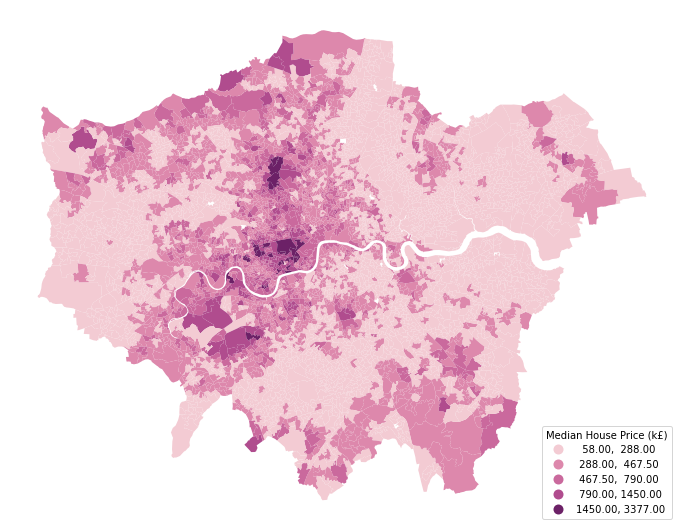

In [6]:
# Fig 1
fig,ax=plt.subplots(1,figsize=(12,10))

gdf.plot(column='kMedianHP',scheme='fisherjenks',cmap=cartos.Magenta_5.mpl_colormap,ax=ax,
         legend=True,legend_kwds={'loc':'lower right','title':'Median House Price (k£)'})

ax.axis('off')

plt.savefig('graph/fig1.png',dpi=200,bbox_inches='tight',facecolor=None)
plt.show()

In [7]:
# check correlation between dependent and independent variables
gdf.corr(method='kendall')['MedianHP']

MedianHP             1.000000
MedianIncome         0.541982
Pct_nonwhite        -0.260607
Pct_CHDC            -0.022876
c_per_hhlds          0.067235
PTAL_average         0.121890
Pct_qual_above_l4    0.507439
kMedianHP            1.000000
Name: MedianHP, dtype: float64

In [8]:
# create a list of all the independent variables
var_n=gdf.columns.tolist()[3:-2]

In [9]:
# remove predictors that are not correlated with the dependent variable
var_n.remove('c_per_hhlds')
var_n.remove('Pct_CHDC')

gdf.drop(['Pct_CHDC','c_per_hhlds'],inplace=True,axis=1)

In [10]:
def vif(df,dep_var,list):
    form=''
    for i in list:
        form+=i
        if i != list[-1]:
            form+='+'
    y,X=dmatrices(dep_var+ ' ~ ' + form, data=df,return_type='dataframe')

    vif=pd.DataFrame()
    vif['VIF']=[variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['variable']=X.columns

    return vif

In [11]:
# check VIF
vif(gdf,'kMedianHP',var_n)

,VIF,variable
0,35.879212,Intercept
1,3.778308,MedianIncome
2,1.561378,Pct_nonwhite
3,1.496724,PTAL_average
4,3.585510,Pct_qual_above_l4


In [12]:
# table 2
gdf.describe()[var_n+['kMedianHP']].T

,count,mean,std,min,25%,50%,75%,max
MedianIncome,4822.0,35796.332020,11448.724483,16167.000,27015.250,32652.000,42290.2500,92431.000
Pct_nonwhite,4822.0,0.392286,0.203428,0.018,0.224,0.368,0.5390,0.965
PTAL_average,4822.0,3.745977,1.602643,0.300,2.595,3.342,4.6645,8.000
Pct_qual_above_l4,4822.0,37.336914,14.534748,8.300,25.825,34.500,47.5000,83.800
kMedianHP,4822.0,330.353782,214.691293,58.000,217.500,268.000,370.0000,3377.000


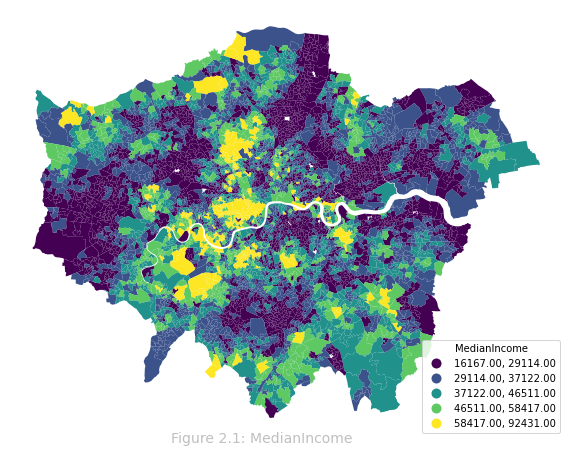

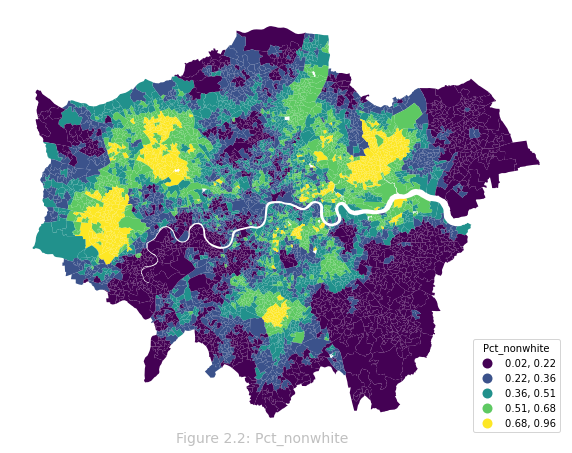

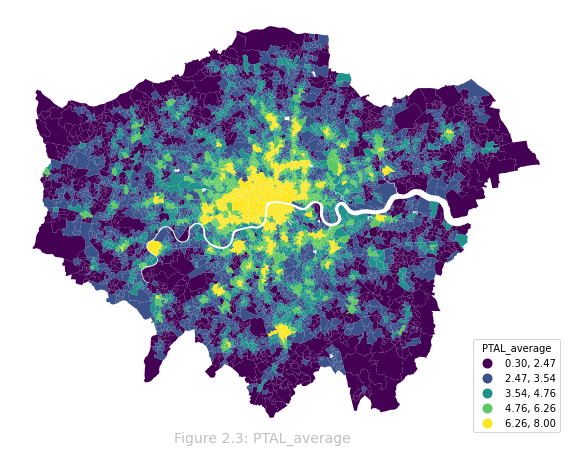

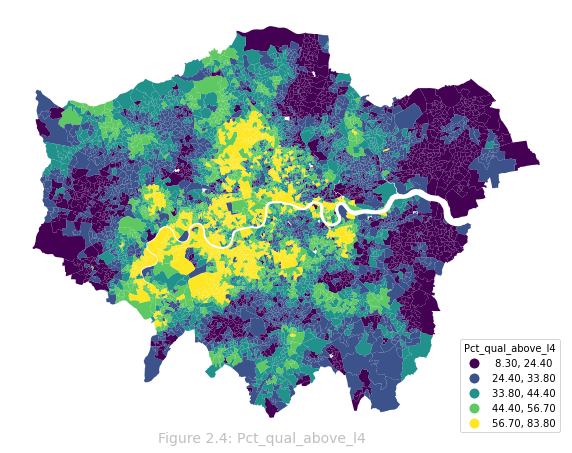

In [13]:
# Fig 2
i=1
for var in var_n:
    fig,ax=plt.subplots(1,figsize=(10,8))
    gdf.plot(column=var,ax=ax,scheme='fisherjenks',cmap='viridis',legend=True,
             legend_kwds={'loc':'lower right','fontsize':10,'title':var})
    ax.axis('off')
    plt.text(x=530000,y=153000,s='Figure 2.'+str(i)+': '+var,
             fontsize=14,color='#c0c0c0',horizontalalignment='center')
    plt.savefig('graph/fig2.'+str(i)+'.png',dpi=200,bbox_inches='tight',facecolor=None)
    i+=1
    plt.show()

In [14]:
# build simple OLS model
m_multi=OLS(gdf[['kMedianHP']].values,
            gdf[var_n].values,
            name_x=var_n,
            name_y='kMedianHP')

print(m_multi.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :   kMedianHP                Number of Observations:        4822
Mean dependent var  :    330.3538                Number of Variables   :           5
S.D. dependent var  :    214.6913                Degrees of Freedom    :        4817
R-squared           :      0.5540
Adjusted R-squared  :      0.5537
Sum squared residual:99098546.109                F-statistic           :   1496.0708
Sigma-square        :   20572.669                Prob(F-statistic)     :           0
S.E. of regression  :     143.432                Log likelihood        :  -30784.994
Sigma-square ML     :   20551.337                Akaike info criterion :   61579.988
S.E of regression ML:    143.3574                Schwarz criterion     :   61612.393

-----------------------------------------------------------------------------

In [15]:
# spatial weights matrix
weights=libpysal.weights.KNN.from_dataframe(gdf,k=6)
weights.transform='r'

In [16]:
# spatial autocorrelation of the OLS residuals
gdf['multi_res']=m_multi.u
multi_res_moran=Moran(m_multi.u,weights)
print(multi_res_moran.I)
print(multi_res_moran.p_sim)

0.40186914690491266
0.001


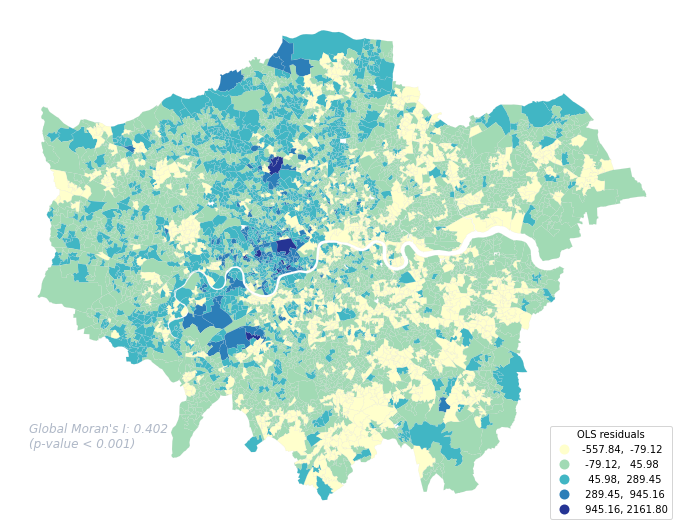

In [17]:
# Fig 3
fig,ax=plt.subplots(1,figsize=(12,10))

gdf.plot(column='multi_res',scheme='FisherJenks',ax=ax,
         cmap=pcs.YlGnBu_5.mpl_colormap,edgecolor='lightgrey',linewidth=0.1,
         legend=True,legend_kwds={'loc':'lower right','title':'OLS residuals'})

plt.figtext(x=0.15,y=0.25,
            s="Global Moran's I: "+str(round(multi_res_moran.I,3))\
                +"\n(p-value < "+str(multi_res_moran.p_sim)+")",
            fontsize=12,fontstyle='italic',color='#afb8c7')
ax.axis('off')

plt.savefig('graph/fig3.png',dpi=200, bbox_inches='tight', facecolor=None)
plt.show()

In [18]:
# prepare data
g_y = gdf['kMedianHP'].values.reshape((-1,1))
g_X = gdf[var_n].values
g_coords=[]
for i in gdf['geometry'].centroid.tolist():
    g_coords.append((i.x,i.y))

# standardise
g_X = (g_X - g_X.mean(axis=0)) / g_X.std(axis=0)

g_y = g_y.reshape((-1,1))

g_y = (g_y - g_y.mean(axis=0)) / g_y.std(axis=0)

In [19]:
# standardised OLS (for comparison)
m_multi=OLS(g_y,g_X,name_x=var_n,name_y='kMedianHP')
print(m_multi.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :   kMedianHP                Number of Observations:        4822
Mean dependent var  :      0.0000                Number of Variables   :           5
S.D. dependent var  :      1.0001                Degrees of Freedom    :        4817
R-squared           :      0.5540
Adjusted R-squared  :      0.5537
Sum squared residual:    2150.446                F-statistic           :   1496.0708
Sigma-square        :       0.446                Prob(F-statistic)     :           0
S.E. of regression  :       0.668                Log likelihood        :   -4895.206
Sigma-square ML     :       0.446                Akaike info criterion :    9800.413
S.E of regression ML:      0.6678                Schwarz criterion     :    9832.817

-----------------------------------------------------------------------------

In [20]:
# Spatial lag model
m_lag=ML_Lag(g_y,g_X,weights,name_x=var_n,name_y='kMedianHP')
print(m_lag.summary)

C:\Users\Yulun\anaconda3\envs\sds2021\lib\site-packages\scipy\optimize\_minimize.py:779: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :   kMedianHP                Number of Observations:        4822
Mean dependent var  :      0.0000                Number of Variables   :           6
S.D. dependent var  :      1.0001                Degrees of Freedom    :        4816
Pseudo R-squared    :      0.7114
Spatial Pseudo R-squared:  0.5418
Sigma-square ML     :       0.289                Log likelihood        :   -4008.245
S.E of regression   :       0.538                Akaike info criterion :    8028.491
                                                 Schwarz criterion     :    8067.377

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------

In [21]:
# select bandwidth
bw=Sel_BW(g_coords,g_y,g_X,fixed=False,kernel='gaussian',spherical=False)
bw.search()

51.0

In [22]:
# build GWR model
m_gwr=GWR(g_coords,g_y,g_X,bw.bw[0],kernel='gaussian')
m_gwr_fit=m_gwr.fit()
m_gwr_fit.summary()

Model type                                                         Gaussian
Number of observations:                                                4822
Number of covariates:                                                     5

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           2150.446
Log-likelihood:                                                   -4895.206
AIC:                                                               9800.413
AICc:                                                              9802.430
BIC:                                                             -38702.262
R2:                                                                   0.554
Adj. R2:                                                              0.554

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [23]:
# mean squared error
mp=pd.Series({'OLS':mse(g_y,m_multi.predy.flatten()),
              'Lag':mse(g_y,m_lag.predy.flatten()),
              'GWR':mse(g_y,m_gwr_fit.predy.flatten())})

mp.sort_values()

GWR    0.197463
Lag    0.289345
OLS    0.445966
dtype: float64

In [24]:
# filter all the statistically insignificant (at 0.05 level) results
f_est=m_gwr_fit.filter_tvals(alpha=.05)

In [25]:
# merge the model result with the original dataframe
data_params=pd.DataFrame(f_est)
data_localR2=pd.DataFrame(m_gwr_fit.localR2)

tem_df=pd.DataFrame(gdf[['Codes','Names','kMedianHP','geometry']])
result_df=tem_df.assign(intercept=data_params[0],
                        MedianIncome=data_params[1],
                        Pct_nonwhite=data_params[2],
                        PTAL_average=data_params[3],
                        Pct_qual_above_l4=data_params[4],
                        localR2=data_localR2[0])

result_gdf=gpd.GeoDataFrame(result_df,geometry='geometry')

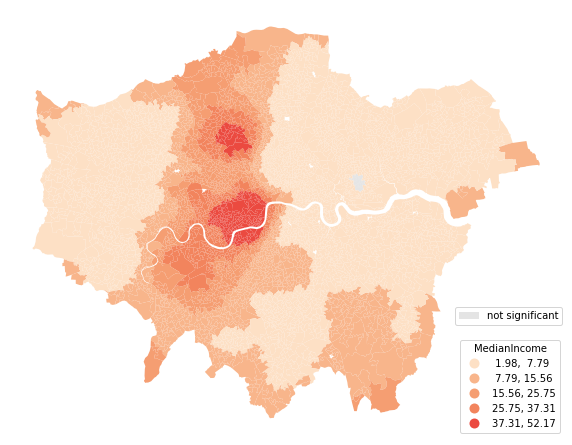

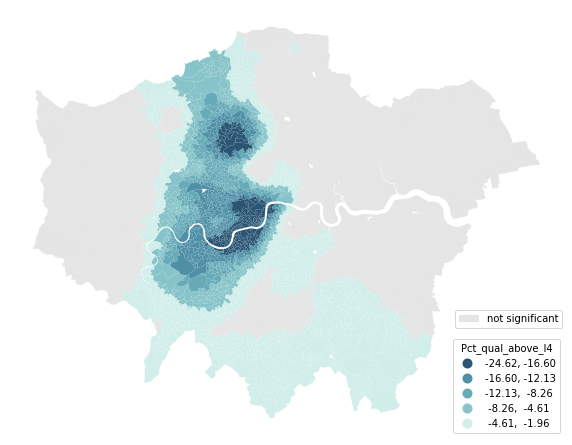

In [26]:
insig=[Patch(facecolor='grey',alpha=.2,label='not significant')]

# Fig 4 and fig 7 (sequential)
# Fig 4
fig,ax=plt.subplots(1,figsize=(10,8))
result_gdf[result_gdf['MedianIncome']==0].plot(color='grey',ax=ax,alpha=.2)

result_gdf[result_gdf['MedianIncome']!=0].\
    plot(column='MedianIncome',cmap=cartos.Peach_5.mpl_colormap,scheme='fisherjenks',
         legend=True,legend_kwds={'loc':'lower right','title':'MedianIncome'},ax=ax)

ax.axis('off')
fig.legend(handles=insig,loc='center',bbox_to_anchor=(0.821,0.34))

plt.savefig('graph/fig4.png',dpi=200,bbox_inches='tight',facecolor=None)
plt.show()

# Fig 7
fig,ax=plt.subplots(1,figsize=(10,8))
result_gdf[result_gdf['Pct_qual_above_l4']==0].plot(color='grey',ax=ax,alpha=.2)

result_gdf[result_gdf['Pct_qual_above_l4']!=0].\
    plot(column='Pct_qual_above_l4',cmap=cartos.Teal_5_r.mpl_colormap,scheme='fisherjenks',
         legend=True,legend_kwds={'loc':'lower right','title':'Pct_qual_above_l4'},ax=ax)

ax.axis('off')
fig.legend(handles=insig,loc='center',bbox_to_anchor=(0.821,0.335))

plt.savefig('graph/fig7.png',dpi=200,bbox_inches='tight',facecolor=None)
plt.show()

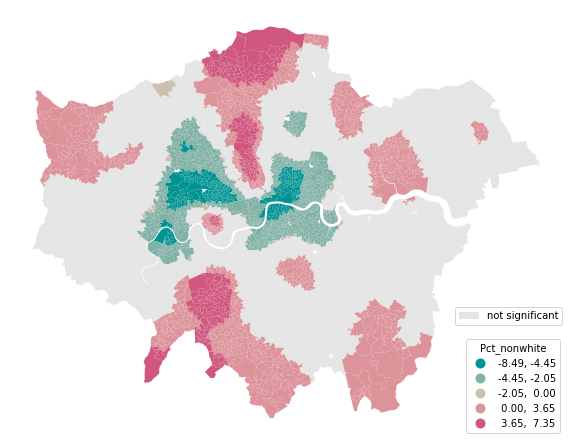

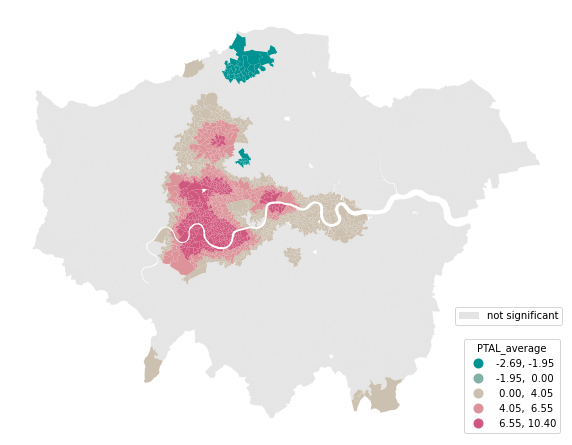

In [27]:
# Fig 5 and fig 6 (diverging)
ud_bins={0:[-4.45,-2.05,0,3.65,7.35],
         1:[-1.95,0,4.05,6.55,10.4]}

for i,row in enumerate(f_est.T[2:-1]):
    fig,ax=plt.subplots(1,figsize=(10,8))
    temp = result_gdf.assign(toplot=f_est.T[i+2])
    temp.query('toplot==0').sort_values('toplot').\
        plot(color='grey',ax=ax,alpha=.2)

    temp.query('toplot!=0').sort_values('toplot').\
        plot('toplot',cmap=cartod.TealRose_6.mpl_colormap,ax=ax,legend=True,
             legend_kwds={'loc':'lower right','title':var_n[i+1]},
             scheme='userdefined',classification_kwds={'bins':ud_bins[i]})
    
    ax.axis('off')
    fig.legend(handles=insig,loc='center',bbox_to_anchor=(0.821,0.34))

    plt.savefig('graph/fig'+str(i+5)+'.png',dpi=200,bbox_inches='tight',facecolor=None)
    plt.show()